In [1]:
from colorscheme import colors

In [2]:
import os
os.chdir(os.path.join('..', '..', '..'))
print(os.getcwd())

/Users/eharkin/Documents/projects/5HTGIF
/Users/eharkin/Documents/projects/5HTGIF


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC
from sklearn.neighbors import LocalOutlierFactor
from statannot import add_stat_annotation
from ezephys import pltools

In [4]:
plt.style.use(os.path.join('figs', 'scripts', 'writeup', 'publication_figure_style.dms'))
plt.rc('text', usetex = False)

In [5]:
IMG_PATH = os.path.join('figs', 'ims', 'writeup', 'GIF_parameters')

# Load data

In [6]:
params = pd.read_csv(os.path.join('analysis', 'model_clustering', 'model_params.csv'))
print(params.shape)

(156, 36)
(156, 36)


In [7]:
params.head()

,C,DV,E_K,El,Tref,Vr,Vt_star,cell_type,dt,eta_10.0,...,h_tau,lambda0,m_A,m_Vhalf,m_k,n_A,n_Vhalf,n_k,name,type
0,0.094361,5.151288,-101.0,-58.838751,6.5,-53.551984,-54.175906,5HT,0.1,0.017711,...,33.0,1.0,1.61,-23.7,0.0985,1.55,-24.3,0.216,DRN307,AugmentedGIF
1,0.114852,3.100761,-101.0,-78.706007,6.5,-54.555621,-52.020721,5HT,0.1,0.031279,...,33.0,1.0,1.61,-23.7,0.0985,1.55,-24.3,0.216,DRN308,AugmentedGIF
2,0.112754,1.247224,-101.0,-63.624398,6.5,-56.135385,-46.530925,5HT,0.1,0.070692,...,61.0,1.0,1.61,-23.7,0.0985,1.55,-24.3,0.216,DRN317,AugmentedGIF
3,0.087860,2.369712,-101.0,-59.121382,6.5,-55.919281,-44.936669,5HT,0.1,0.022100,...,82.0,1.0,1.61,-23.7,0.0985,1.55,-24.3,0.216,DRN318,AugmentedGIF
4,0.121158,4.977856,-101.0,-50.061295,6.5,-49.185461,-58.738916,5HT,0.1,0.048414,...,33.0,1.0,1.61,-23.7,0.0985,1.55,-24.3,0.216,DRN319,AugmentedGIF


,C,DV,E_K,El,Tref,Vr,Vt_star,cell_type,dt,eta_10.0,...,h_tau,lambda0,m_A,m_Vhalf,m_k,n_A,n_Vhalf,n_k,name,type
0,0.094361,5.151288,-101.0,-58.838751,6.5,-53.551984,-54.175906,5HT,0.1,0.017711,...,33.0,1.0,1.61,-23.7,0.0985,1.55,-24.3,0.216,DRN307,AugmentedGIF
1,0.114852,3.100761,-101.0,-78.706007,6.5,-54.555621,-52.020721,5HT,0.1,0.031279,...,33.0,1.0,1.61,-23.7,0.0985,1.55,-24.3,0.216,DRN308,AugmentedGIF
2,0.112754,1.247224,-101.0,-63.624398,6.5,-56.135385,-46.530925,5HT,0.1,0.070692,...,61.0,1.0,1.61,-23.7,0.0985,1.55,-24.3,0.216,DRN317,AugmentedGIF
3,0.087860,2.369712,-101.0,-59.121382,6.5,-55.919281,-44.936669,5HT,0.1,0.022100,...,82.0,1.0,1.61,-23.7,0.0985,1.55,-24.3,0.216,DRN318,AugmentedGIF
4,0.121158,4.977856,-101.0,-50.061295,6.5,-49.185461,-58.738916,5HT,0.1,0.048414,...,33.0,1.0,1.61,-23.7,0.0985,1.55,-24.3,0.216,DRN319,AugmentedGIF


In [8]:
params.columns

Index([u'C', u'DV', u'E_K', u'El', u'Tref', u'Vr', u'Vt_star', u'cell_type',
       u'dt', u'eta_10.0', u'eta_100.0', u'eta_1000.0', u'eta_3.0',
       u'eta_30.0', u'eta_300.0', u'eta_3000.0', u'gamma_3.0', u'gamma_30.0',
       u'gamma_300.0', u'gamma_3000.0', u'gbar_K1', u'gbar_K2', u'gl', u'h_A',
       u'h_Vhalf', u'h_k', u'h_tau', u'lambda0', u'm_A', u'm_Vhalf', u'm_k',
       u'n_A', u'n_Vhalf', u'n_k', u'name', u'type'],
      dtype='object')

Index([u'C', u'DV', u'E_K', u'El', u'Tref', u'Vr', u'Vt_star', u'cell_type',
       u'dt', u'eta_10.0', u'eta_100.0', u'eta_1000.0', u'eta_3.0',
       u'eta_30.0', u'eta_300.0', u'eta_3000.0', u'gamma_3.0', u'gamma_30.0',
       u'gamma_300.0', u'gamma_3000.0', u'gbar_K1', u'gbar_K2', u'gl', u'h_A',
       u'h_Vhalf', u'h_k', u'h_tau', u'lambda0', u'm_A', u'm_Vhalf', u'm_k',
       u'n_A', u'n_Vhalf', u'n_k', u'name', u'type'],
      dtype='object')

# Select GIFs and remove unnecessary features

In [9]:
params_cleaned = params.copy()
params_cleaned.drop(columns=['Tref', 'dt', 'E_K', 'gbar_K1', 'gbar_K2', 'h_A', 'h_Vhalf', 'h_k', 'lambda0', 'm_A', 'm_Vhalf', 'm_k', 'n_A', 'n_Vhalf', 'n_k', 'h_tau'], inplace=True)
params_cleaned = params_cleaned.loc[params_cleaned['type'] == 'GIF', :]
params_cleaned.drop(columns=['name', 'type'], inplace=True)

cell_types = params_cleaned['cell_type']
params_cleaned.drop(columns=['cell_type'], inplace=True)

params_cleaned.head()

,C,DV,El,Vr,Vt_star,eta_10.0,eta_100.0,eta_1000.0,eta_3.0,eta_30.0,eta_300.0,eta_3000.0,gamma_3.0,gamma_30.0,gamma_300.0,gamma_3000.0,gl
18,0.099165,6.537423,-64.456700,-53.551984,-55.723169,0.008590,0.028477,0.002652,0.055727,-0.003865,-0.000222,0.000670,68849.738479,-46.686658,6.983622,5.327227,0.001101
19,0.121812,4.442023,-80.402978,-54.555621,-54.317823,0.024262,0.038746,0.008135,0.079653,-0.013658,0.007560,-0.003254,-63.497849,60.990898,37.533114,2.546485,0.001341
20,0.115125,2.417979,-64.851407,-56.135385,-49.111013,0.068537,0.055866,0.002841,-0.025442,-0.022652,0.006485,-0.001052,-94.415131,91.663755,10.192265,0.146151,0.002272
21,0.094173,3.813900,-63.565351,-55.919281,-46.181507,0.017409,0.057299,0.003776,-0.016150,-0.002213,-0.003999,-0.000593,-176.953457,185.704229,6.839458,-0.171109,0.001654
22,0.105769,4.568117,-54.186544,-49.185461,-59.392968,0.030981,0.007375,0.007067,-0.067469,0.026209,0.000226,-0.006007,807.045568,-1.874450,0.443651,2.199422,0.001898


,C,DV,El,Vr,Vt_star,eta_10.0,eta_100.0,eta_1000.0,eta_3.0,eta_30.0,eta_300.0,eta_3000.0,gamma_3.0,gamma_30.0,gamma_300.0,gamma_3000.0,gl
18,0.099165,6.537423,-64.456700,-53.551984,-55.723169,0.008590,0.028477,0.002652,0.055727,-0.003865,-0.000222,0.000670,68849.738479,-46.686658,6.983622,5.327227,0.001101
19,0.121812,4.442023,-80.402978,-54.555621,-54.317823,0.024262,0.038746,0.008135,0.079653,-0.013658,0.007560,-0.003254,-63.497849,60.990898,37.533114,2.546485,0.001341
20,0.115125,2.417979,-64.851407,-56.135385,-49.111013,0.068537,0.055866,0.002841,-0.025442,-0.022652,0.006485,-0.001052,-94.415131,91.663755,10.192265,0.146151,0.002272
21,0.094173,3.813900,-63.565351,-55.919281,-46.181507,0.017409,0.057299,0.003776,-0.016150,-0.002213,-0.003999,-0.000593,-176.953457,185.704229,6.839458,-0.171109,0.001654
22,0.105769,4.568117,-54.186544,-49.185461,-59.392968,0.030981,0.007375,0.007067,-0.067469,0.026209,0.000226,-0.006007,807.045568,-1.874450,0.443651,2.199422,0.001898


In [10]:
print(params_cleaned.columns)

Index([u'C', u'DV', u'El', u'Vr', u'Vt_star', u'eta_10.0', u'eta_100.0',
       u'eta_1000.0', u'eta_3.0', u'eta_30.0', u'eta_300.0', u'eta_3000.0',
       u'gamma_3.0', u'gamma_30.0', u'gamma_300.0', u'gamma_3000.0', u'gl'],
      dtype='object')
Index([u'C', u'DV', u'El', u'Vr', u'Vt_star', u'eta_10.0', u'eta_100.0',
       u'eta_1000.0', u'eta_3.0', u'eta_30.0', u'eta_300.0', u'eta_3000.0',
       u'gamma_3.0', u'gamma_30.0', u'gamma_300.0', u'gamma_3000.0', u'gl'],
      dtype='object')


In [11]:
print(params_cleaned.shape)

(39, 17)
(39, 17)


# Detect outliers

/miniconda3/envs/neopozz/lib/python2.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


(array([26.,  7.,  2.,  0.,  1.,  1.,  0.,  0.,  1.,  1.]),
 array([-5.02640366e-03,  5.01821096e-01,  1.00866860e+00,  1.51551610e+00,
         2.02236360e+00,  2.52921110e+00,  3.03605860e+00,  3.54290610e+00,
         4.04975360e+00,  4.55660110e+00,  5.06344860e+00]),
 <a list of 10 Patch objects>)

/miniconda3/envs/neopozz/lib/python2.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


(array([26.,  7.,  2.,  0.,  1.,  1.,  0.,  0.,  1.,  1.]),
 array([-5.02640366e-03,  5.01821096e-01,  1.00866860e+00,  1.51551610e+00,
         2.02236360e+00,  2.52921110e+00,  3.03605860e+00,  3.54290610e+00,
         4.04975360e+00,  4.55660110e+00,  5.06344860e+00]),
 <a list of 10 Patch objects>)

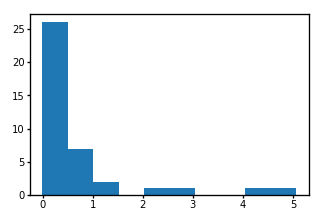

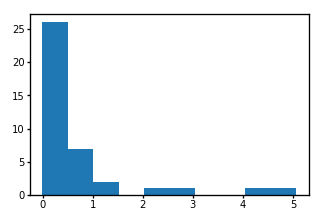

In [12]:
outlier_detector = LocalOutlierFactor(n_neighbors=20)
outlier_detector.fit(params_cleaned)
plt.hist(np.log10(-outlier_detector.negative_outlier_factor_))

In [13]:
cell_types[np.log10(-outlier_detector.negative_outlier_factor_) > 4.]

28    5HT
29    5HT
Name: cell_type, dtype: object

28    5HT
29    5HT
Name: cell_type, dtype: object

In [14]:
params_cleaned.drop(
    index=cell_types[np.log10(-outlier_detector.negative_outlier_factor_) > 4.].index,
    inplace=True
)
cell_types.drop(
    index=cell_types[np.log10(-outlier_detector.negative_outlier_factor_) > 4.].index, 
    inplace=True
)

In [15]:
params_cleaned.columns

Index([u'C', u'DV', u'El', u'Vr', u'Vt_star', u'eta_10.0', u'eta_100.0',
       u'eta_1000.0', u'eta_3.0', u'eta_30.0', u'eta_300.0', u'eta_3000.0',
       u'gamma_3.0', u'gamma_30.0', u'gamma_300.0', u'gamma_3000.0', u'gl',
       u'cell_type'],
      dtype='object')

Index([u'C', u'DV', u'El', u'Vr', u'Vt_star', u'eta_10.0', u'eta_100.0',
       u'eta_1000.0', u'eta_3.0', u'eta_30.0', u'eta_300.0', u'eta_3000.0',
       u'gamma_3.0', u'gamma_30.0', u'gamma_300.0', u'gamma_3000.0', u'gl',
       u'cell_type'],
      dtype='object')

In [16]:
params_cleaned.drop(columns='cell_type', inplace=True)

Not sure why `cell_type` has to be dropped twice...

# Reorder columns

In [17]:
column_order = [
    'gl', 'C', 'El', 
    'Vt_star', 'DV', 'Vr', 
    'eta_3.0', 'eta_10.0', 'eta_30.0', 'eta_100.0', 'eta_300.0', 'eta_1000.0', 'eta_3000.0',
    'gamma_3.0', 'gamma_30.0', 'gamma_300.0', 'gamma_3000.0'
]

In [18]:
params_cleaned = params_cleaned[column_order]
params_cleaned

,gl,C,El,Vt_star,DV,Vr,eta_3.0,eta_10.0,eta_30.0,eta_100.0,eta_300.0,eta_1000.0,eta_3000.0,gamma_3.0,gamma_30.0,gamma_300.0,gamma_3000.0
18,0.001101,0.099165,-64.456700,-55.723169,6.537423,-53.551984,0.055727,0.008590,-0.003865,0.028477,-0.000222,0.002652,0.000670,68849.738479,-46.686658,6.983622,5.327227
19,0.001341,0.121812,-80.402978,-54.317823,4.442023,-54.555621,0.079653,0.024262,-0.013658,0.038746,0.007560,0.008135,-0.003254,-63.497849,60.990898,37.533114,2.546485
20,0.002272,0.115125,-64.851407,-49.111013,2.417979,-56.135385,-0.025442,0.068537,-0.022652,0.055866,0.006485,0.002841,-0.001052,-94.415131,91.663755,10.192265,0.146151
21,0.001654,0.094173,-63.565351,-46.181507,3.813900,-55.919281,-0.016150,0.017409,-0.002213,0.057299,-0.003999,0.003776,-0.000593,-176.953457,185.704229,6.839458,-0.171109
22,0.001898,0.105769,-54.186544,-59.392968,4.568117,-49.185461,-0.067469,0.030981,0.026209,0.007375,0.000226,0.007067,-0.006007,807.045568,-1.874450,0.443651,2.199422
23,0.001480,0.105986,-77.660459,-54.206555,3.660197,-55.910230,0.122361,-0.029524,0.018548,0.002862,0.032210,-0.002710,0.001136,-103.833594,90.221830,47.777383,0.297055
24,0.001010,0.075368,-58.451185,-60.727573,7.103950,-53.856620,0.073772,-0.005191,0.001387,0.018662,0.004873,-0.000693,0.001612,2015.267924,-35.986808,7.202479,3.419390
25,0.001346,0.057376,-58.943020,-52.318925,4.481108,-50.654675,0.089957,-0.009948,0.020625,0.016925,0.007852,0.001487,0.000247,444.556618,7.255312,7.234137,-0.074491
26,0.001275,0.060406,-65.865833,-59.170470,8.549067,-63.857361,0.028474,-0.035922,0.014603,0.004706,0.004222,0.002032,-0.001413,472.443320,2.151137,8.928289,-1.034216
27,0.001284,0.086364,-61.547472,-47.200642,3.810645,-47.654813,0.258201,-0.019938,0.004317,0.026538,0.018541,-0.000599,-0.000116,-77.760406,80.096591,26.178384,-1.310189


,gl,C,El,Vt_star,DV,Vr,eta_3.0,eta_10.0,eta_30.0,eta_100.0,eta_300.0,eta_1000.0,eta_3000.0,gamma_3.0,gamma_30.0,gamma_300.0,gamma_3000.0
18,0.001101,0.099165,-64.456700,-55.723169,6.537423,-53.551984,0.055727,0.008590,-0.003865,0.028477,-0.000222,0.002652,0.000670,68849.738479,-46.686658,6.983622,5.327227
19,0.001341,0.121812,-80.402978,-54.317823,4.442023,-54.555621,0.079653,0.024262,-0.013658,0.038746,0.007560,0.008135,-0.003254,-63.497849,60.990898,37.533114,2.546485
20,0.002272,0.115125,-64.851407,-49.111013,2.417979,-56.135385,-0.025442,0.068537,-0.022652,0.055866,0.006485,0.002841,-0.001052,-94.415131,91.663755,10.192265,0.146151
21,0.001654,0.094173,-63.565351,-46.181507,3.813900,-55.919281,-0.016150,0.017409,-0.002213,0.057299,-0.003999,0.003776,-0.000593,-176.953457,185.704229,6.839458,-0.171109
22,0.001898,0.105769,-54.186544,-59.392968,4.568117,-49.185461,-0.067469,0.030981,0.026209,0.007375,0.000226,0.007067,-0.006007,807.045568,-1.874450,0.443651,2.199422
23,0.001480,0.105986,-77.660459,-54.206555,3.660197,-55.910230,0.122361,-0.029524,0.018548,0.002862,0.032210,-0.002710,0.001136,-103.833594,90.221830,47.777383,0.297055
24,0.001010,0.075368,-58.451185,-60.727573,7.103950,-53.856620,0.073772,-0.005191,0.001387,0.018662,0.004873,-0.000693,0.001612,2015.267924,-35.986808,7.202479,3.419390
25,0.001346,0.057376,-58.943020,-52.318925,4.481108,-50.654675,0.089957,-0.009948,0.020625,0.016925,0.007852,0.001487,0.000247,444.556618,7.255312,7.234137,-0.074491
26,0.001275,0.060406,-65.865833,-59.170470,8.549067,-63.857361,0.028474,-0.035922,0.014603,0.004706,0.004222,0.002032,-0.001413,472.443320,2.151137,8.928289,-1.034216
27,0.001284,0.086364,-61.547472,-47.200642,3.810645,-47.654813,0.258201,-0.019938,0.004317,0.026538,0.018541,-0.000599,-0.000116,-77.760406,80.096591,26.178384,-1.310189


# PCA

In [19]:
def rescale_variables(x):
    """Subtract mean and normalize to SD for each column of a dataframe or array.
    Returns a copy.
    """
    output = x.copy()
    
    try:
        # Method for pd.DataFrames
        output.iloc # Test if x is DataFrame-like
        
        for colname in output:
            output[colname] = output[colname] - np.mean(output[colname])
            output[colname] = output[colname] / np.std(output[colname])
    
    except AttributeError:
        # Method for np.arrays.
        output[0, 0] # Test if x is array-like
        
        output -= output.mean(axis = 0)
        output /= output.std(axis = 0)
        
    return output

In [20]:
def rescale_variables_nonparametric(x):
    """Subtract median and divide by interquartile range for each column of x."""
    output = x.copy()
    
    try:
        # Method for pd.DataFrames
        output.iloc # Test if x is DataFrame-like
        
        for colname in output:
            output[colname] = output[colname] - np.median(output[colname])
            output[colname] = output[colname] / stats.iqr(output[colname])
    
    except AttributeError:
        # Method for np.arrays.
        output[0, 0] # Test if x is array-like
        
        output -= output.median(axis = 0)
        output /= stats.iqr(output, axis=0)
        
    return output

In [21]:
pca = PCA()
transformed = pca.fit_transform(rescale_variables(params_cleaned))

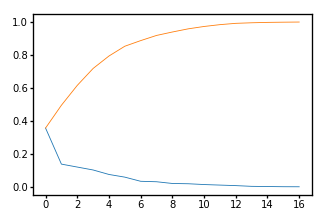

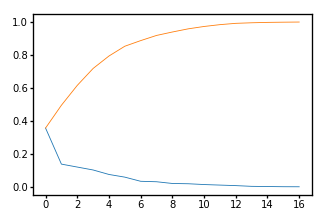

In [22]:
plt.plot(pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

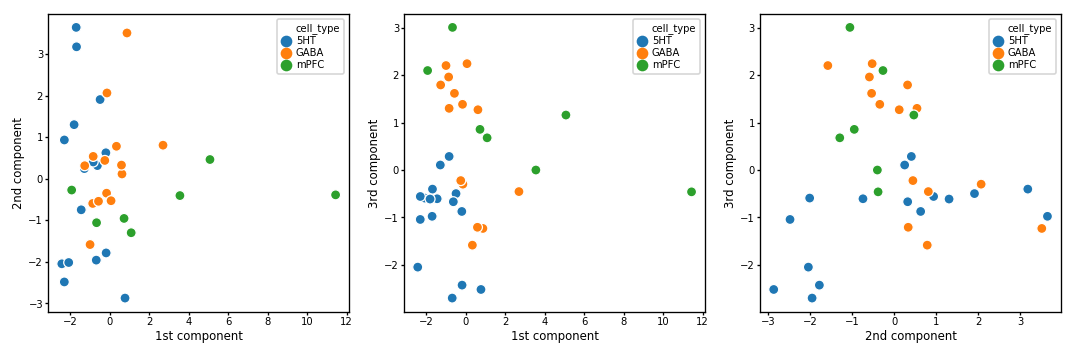

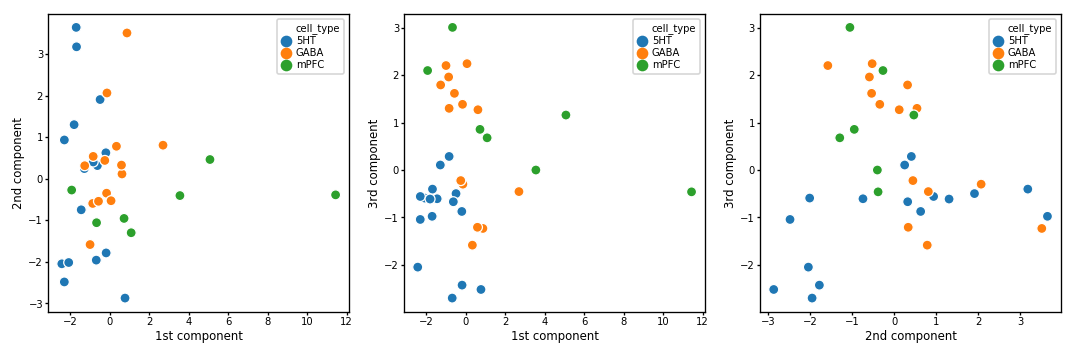

In [23]:
plt.figure(figsize=(9, 3))

plt.subplot(131)
sns.scatterplot(x=transformed[:, 0], y=transformed[:, 1], hue=cell_types)
plt.xlabel('1st component')
plt.ylabel('2nd component')

plt.subplot(132)
sns.scatterplot(x=transformed[:, 0], y=transformed[:, 2], hue=cell_types)
plt.xlabel('1st component')
plt.ylabel('3rd component')

plt.subplot(133)
sns.scatterplot(x=transformed[:, 1], y=transformed[:, 2], hue=cell_types)
plt.xlabel('2nd component')
plt.ylabel('3rd component')

plt.tight_layout()
plt.show()

# ICA

In [24]:
ica = FastICA(n_components=3, whiten=True, random_state=42)
ica_transformed = ica.fit_transform(rescale_variables(params_cleaned))
ica_transformed.shape

(37, 3)

(37, 3)

In [25]:
params_cleaned.columns

Index([u'gl', u'C', u'El', u'Vt_star', u'DV', u'Vr', u'eta_3.0', u'eta_10.0',
       u'eta_30.0', u'eta_100.0', u'eta_300.0', u'eta_1000.0', u'eta_3000.0',
       u'gamma_3.0', u'gamma_30.0', u'gamma_300.0', u'gamma_3000.0'],
      dtype='object')

Index([u'gl', u'C', u'El', u'Vt_star', u'DV', u'Vr', u'eta_3.0', u'eta_10.0',
       u'eta_30.0', u'eta_100.0', u'eta_300.0', u'eta_1000.0', u'eta_3000.0',
       u'gamma_3.0', u'gamma_30.0', u'gamma_300.0', u'gamma_3000.0'],
      dtype='object')

[Text(0,1,'gl'),
 Text(0,1,'C'),
 Text(0,1,'El'),
 Text(0,1,'Vt_star'),
 Text(0,1,'DV'),
 Text(0,1,'Vr'),
 Text(0,1,'eta_3.0'),
 Text(0,1,'eta_10.0'),
 Text(0,1,'eta_30.0'),
 Text(0,1,'eta_100.0'),
 Text(0,1,'eta_300.0'),
 Text(0,1,'eta_1000.0'),
 Text(0,1,'eta_3000.0'),
 Text(0,1,'gamma_3.0'),
 Text(0,1,'gamma_30.0'),
 Text(0,1,'gamma_300.0'),
 Text(0,1,'gamma_3000.0')]

[Text(0,1,'gl'),
 Text(0,1,'C'),
 Text(0,1,'El'),
 Text(0,1,'Vt_star'),
 Text(0,1,'DV'),
 Text(0,1,'Vr'),
 Text(0,1,'eta_3.0'),
 Text(0,1,'eta_10.0'),
 Text(0,1,'eta_30.0'),
 Text(0,1,'eta_100.0'),
 Text(0,1,'eta_300.0'),
 Text(0,1,'eta_1000.0'),
 Text(0,1,'eta_3000.0'),
 Text(0,1,'gamma_3.0'),
 Text(0,1,'gamma_30.0'),
 Text(0,1,'gamma_300.0'),
 Text(0,1,'gamma_3000.0')]

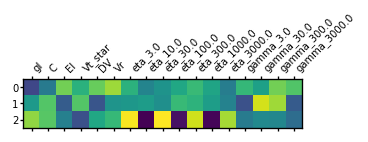

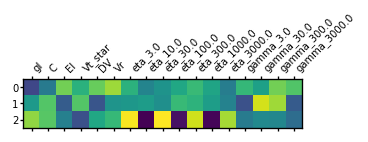

In [26]:
ax = plt.subplot(111)
ax.matshow(ica.mixing_.T)
ax.set_xticks(np.arange(0, len(params_cleaned.columns)))
ax.set_xticklabels(params_cleaned.columns, rotation=45, ha='left')

[Text(0,0,'gl'),
 Text(0,0,'C'),
 Text(0,0,'El'),
 Text(0,0,'Vt_star'),
 Text(0,0,'DV'),
 Text(0,0,'Vr'),
 Text(0,0,'eta_3.0'),
 Text(0,0,'eta_10.0'),
 Text(0,0,'eta_30.0'),
 Text(0,0,'eta_100.0'),
 Text(0,0,'eta_300.0'),
 Text(0,0,'eta_1000.0'),
 Text(0,0,'eta_3000.0'),
 Text(0,0,'gamma_3.0'),
 Text(0,0,'gamma_30.0'),
 Text(0,0,'gamma_300.0'),
 Text(0,0,'gamma_3000.0')]

[Text(0,0,'gl'),
 Text(0,0,'C'),
 Text(0,0,'El'),
 Text(0,0,'Vt_star'),
 Text(0,0,'DV'),
 Text(0,0,'Vr'),
 Text(0,0,'eta_3.0'),
 Text(0,0,'eta_10.0'),
 Text(0,0,'eta_30.0'),
 Text(0,0,'eta_100.0'),
 Text(0,0,'eta_300.0'),
 Text(0,0,'eta_1000.0'),
 Text(0,0,'eta_3000.0'),
 Text(0,0,'gamma_3.0'),
 Text(0,0,'gamma_30.0'),
 Text(0,0,'gamma_300.0'),
 Text(0,0,'gamma_3000.0')]

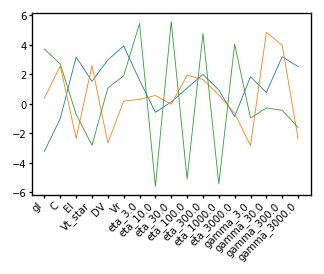

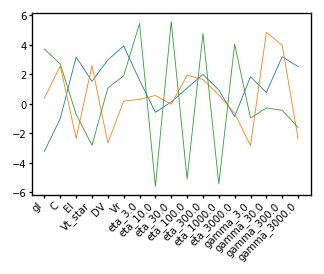

In [27]:
plt.plot(ica.mixing_)
plt.gca().set_xticks(np.arange(0, len(params_cleaned.columns)))
plt.gca().set_xticklabels(params_cleaned.columns, rotation=45, ha='right')

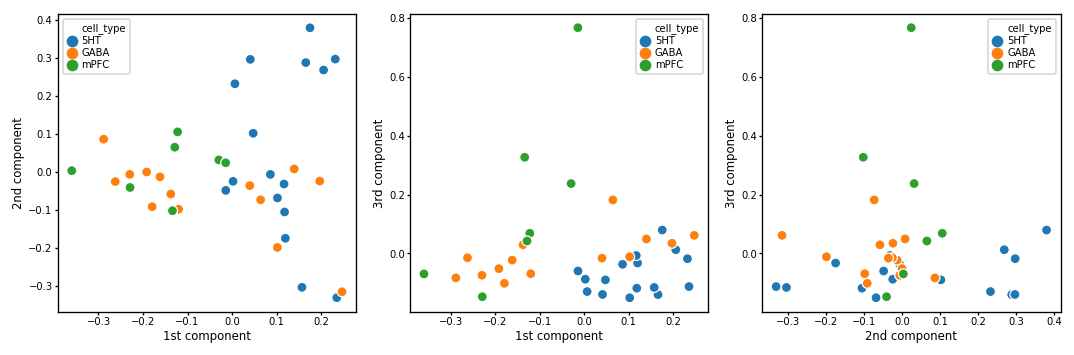

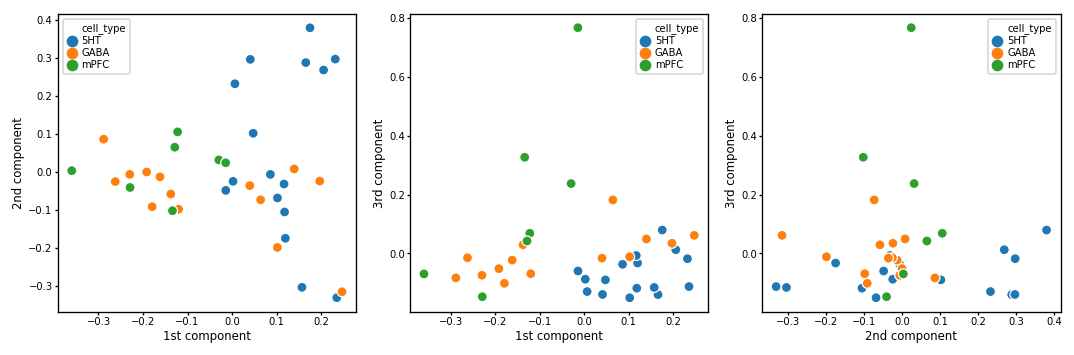

In [28]:
plt.figure(figsize=(9, 3))

plt.subplot(131)
sns.scatterplot(x=ica_transformed[:, 0], y=ica_transformed[:, 1], hue=cell_types)
plt.xlabel('1st component')
plt.ylabel('2nd component')

plt.subplot(132)
sns.scatterplot(x=ica_transformed[:, 0], y=ica_transformed[:, 2], hue=cell_types)
plt.xlabel('1st component')
plt.ylabel('3rd component')

plt.subplot(133)
sns.scatterplot(x=ica_transformed[:, 1], y=ica_transformed[:, 2], hue=cell_types)
plt.xlabel('2nd component')
plt.ylabel('3rd component')

plt.tight_layout()
plt.show()

# Train a classifier on PCA components

In [29]:
centered_svm = LinearSVC(fit_intercept=False)
centered_svm.fit(transformed[(cell_types != 'mPFC'), :], cell_types[(cell_types != 'mPFC')])

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=False,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=False,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [30]:
centered_svm.coef_.shape

(1, 17)

(1, 17)

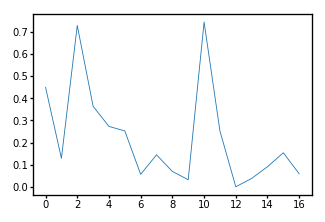

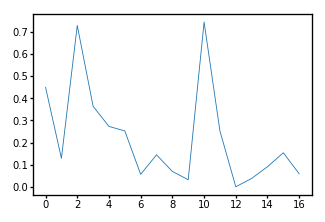

In [31]:
plt.plot(np.abs(centered_svm.coef_.T))

In [32]:
relative_importance = np.argsort(np.abs(centered_svm.coef_).flatten())
relative_importance

array([12,  9, 13,  6, 16,  8, 14,  1,  7, 15, 11,  5,  4,  3,  0,  2, 10])

array([12,  9, 13,  6, 16,  8, 14,  1,  7, 15, 11,  5,  4,  3,  0,  2, 10])

In [33]:
def iteratively_drop_features(classifier, x, y):
    x = np.copy(x)
    y = np.copy(y)
    
    scores = []
    remaining_features = [i for i in range(x.shape[1])]
    feature_drop_order = []  # Features in order of increasing importance.
    for i in range(x.shape[1]):
        classifier.fit(x[:, remaining_features], y)
        scores.append(classifier.score(x[:, remaining_features], y))
        
        # Pop least important remaining feature.
        feature_drop_order.append(
            remaining_features.pop(np.argmin(np.abs(classifier.coef_)))
        )
    
    return scores, feature_drop_order

In [34]:
scores, feature_drop_order = iteratively_drop_features(
    centered_svm, 
    transformed[(cell_types != 'mPFC'), :], 
    cell_types[(cell_types != 'mPFC')]
)
scores

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.8,
 0.7666666666666667]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.8,
 0.7666666666666667]

We can separate 5HT and GABA cells perfectly using only three components.

In [35]:
print(feature_drop_order)

[12, 9, 13, 6, 8, 16, 1, 14, 7, 15, 5, 11, 4, 3, 2, 0, 10]
[12, 9, 13, 6, 8, 16, 1, 14, 7, 15, 5, 11, 4, 3, 2, 0, 10]


([<matplotlib.axis.XTick at 0x1a2742ded0>,
 <a list of 17 Text xticklabel objects>)

([<matplotlib.axis.XTick at 0x1a2742ded0>,
 <a list of 17 Text xticklabel objects>)

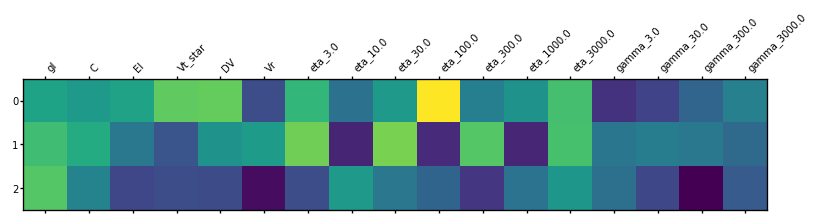

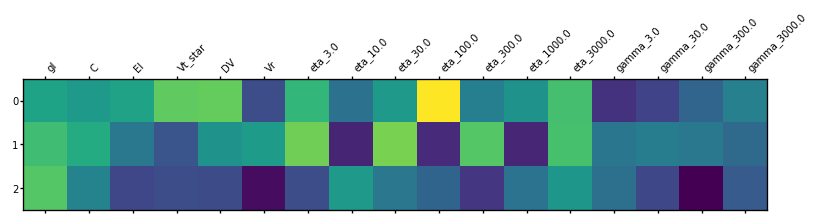

In [36]:
plt.figure(figsize=(8, 8))
plt.matshow(pca.components_[feature_drop_order[-1:-4:-1], :], fignum=False)
plt.xticks(np.arange(0, pca.components_.shape[1]), params_cleaned.columns.tolist(), rotation=45, ha='left')

# Train classifier on rescaled variables

## 5HT vs SOM

In [37]:
reduced_svm = LinearSVC(fit_intercept=False)
rescaled = rescale_variables(params_cleaned)
scores, feature_drop_order = iteratively_drop_features(
    reduced_svm, 
    np.asarray(rescaled)[cell_types != 'mPFC', :], 
    cell_types[cell_types != 'mPFC']
)
scores

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9,
 0.9333333333333333]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9,
 0.9333333333333333]

In [38]:
features_in_increasing_importance = np.array(params_cleaned.columns.tolist())[feature_drop_order]
features_in_increasing_importance

array(['gamma_30.0', 'El', 'eta_10.0', 'eta_30.0', 'C', 'gl', 'gamma_3.0',
       'eta_3000.0', 'Vr', 'gamma_3000.0', 'gamma_300.0', 'eta_3.0', 'DV',
       'Vt_star', 'eta_1000.0', 'eta_300.0', 'eta_100.0'], dtype='|S12')

array(['gamma_30.0', 'El', 'eta_10.0', 'eta_30.0', 'C', 'gl', 'gamma_3.0',
       'eta_3000.0', 'Vr', 'gamma_3000.0', 'gamma_300.0', 'eta_3.0', 'DV',
       'Vt_star', 'eta_1000.0', 'eta_300.0', 'eta_100.0'], dtype='|S12')

Features in order of increasing importance.

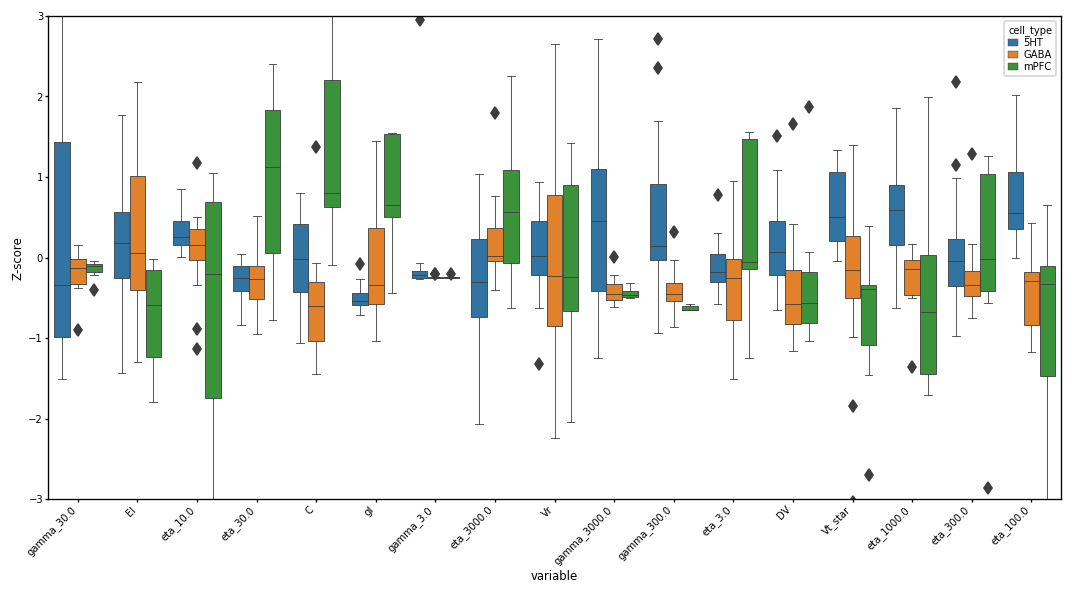

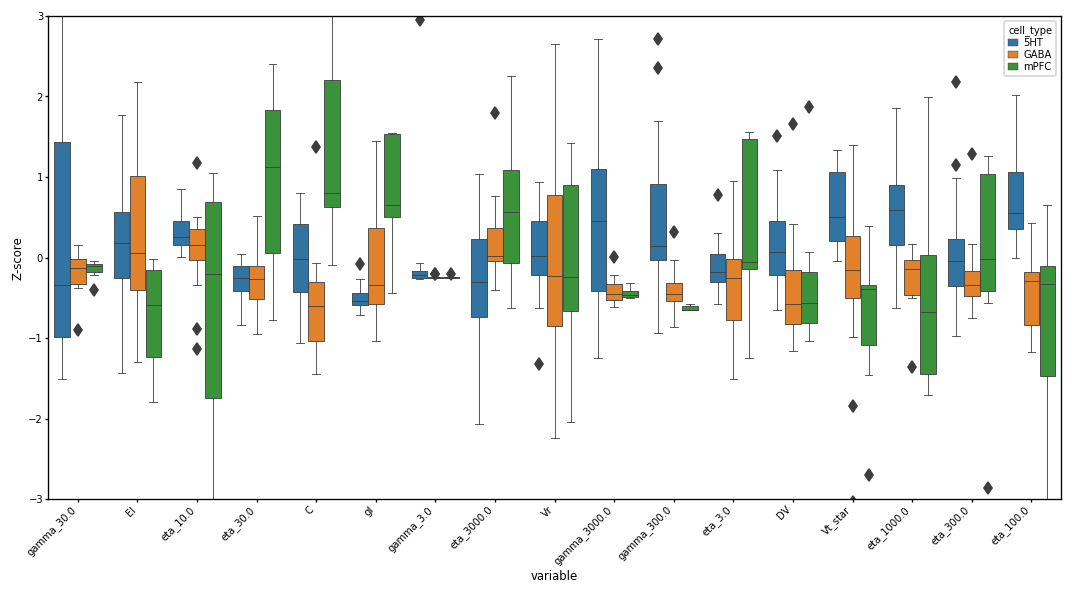

In [39]:
plt.figure(figsize=(9, 5))
sns.boxplot(
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([rescaled, cell_types], axis=1).melt(id_vars='cell_type'),
    order = features_in_increasing_importance
)
plt.ylim(-3, 3)
tick_locs, tick_labs = plt.xticks()
plt.xticks(*plt.xticks(), rotation=45, ha='right')
plt.ylabel('Z-score')
plt.tight_layout()

## 5HT vs. mPFC

In [40]:
reduced_svm = LinearSVC(fit_intercept=False)
scores, feature_drop_order = iteratively_drop_features(
    reduced_svm, 
    np.asarray(rescaled)[cell_types != 'GABA', :], 
    cell_types[cell_types != 'GABA']
)
scores

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9565217391304348,
 0.9565217391304348,
 0.9565217391304348]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9565217391304348,
 0.9565217391304348,
 0.9565217391304348]

In [41]:
features_in_increasing_importance = np.array(params_cleaned.columns.tolist())[feature_drop_order]
features_in_increasing_importance

array(['Vr', 'gamma_3.0', 'eta_3.0', 'gamma_30.0', 'eta_30.0', 'El',
       'eta_1000.0', 'eta_300.0', 'gamma_3000.0', 'eta_3000.0',
       'gamma_300.0', 'DV', 'eta_100.0', 'C', 'eta_10.0', 'Vt_star', 'gl'],
      dtype='|S12')

array(['Vr', 'gamma_3.0', 'eta_3.0', 'gamma_30.0', 'eta_30.0', 'El',
       'eta_1000.0', 'eta_300.0', 'gamma_3000.0', 'eta_3000.0',
       'gamma_300.0', 'DV', 'eta_100.0', 'C', 'eta_10.0', 'Vt_star', 'gl'],
      dtype='|S12')

Features in order of increasing importance.

Text(111.917,0.5,'Z-score')

Text(111.917,0.5,'Z-score')

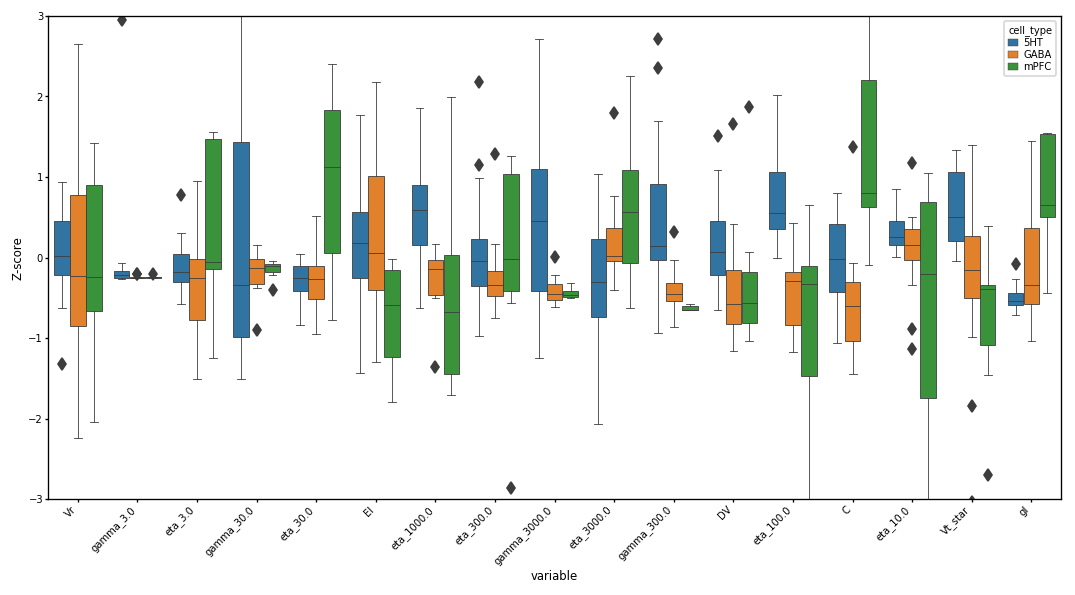

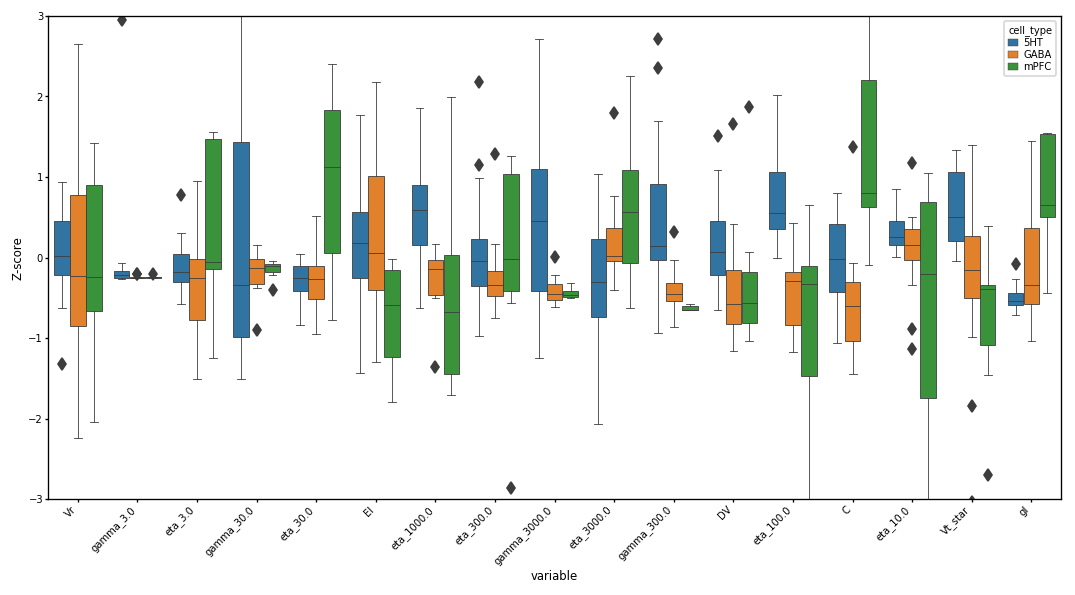

In [42]:
plt.figure(figsize=(9, 5))
sns.boxplot(
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([rescaled, cell_types], axis=1).melt(id_vars='cell_type'),
    order = features_in_increasing_importance
)
plt.ylim(-3, 3)
tick_locs, tick_labs = plt.xticks()
plt.xticks(*plt.xticks(), rotation=45, ha='right')
plt.tight_layout()
plt.ylabel('Z-score')

# Show variables in a sensible order with non-parametric rescaling

In [43]:
params_cleaned['thresh_dist'] = params_cleaned['Vt_star'] - params_cleaned['El']
params_cleaned['time_const'] = params_cleaned['C'] / params_cleaned['gl']

In [44]:
rescaled_nonparametric = rescale_variables_nonparametric(params_cleaned)

Text(107.667,0.5,'IQRs from median')

Text(107.667,0.5,'IQRs from median')

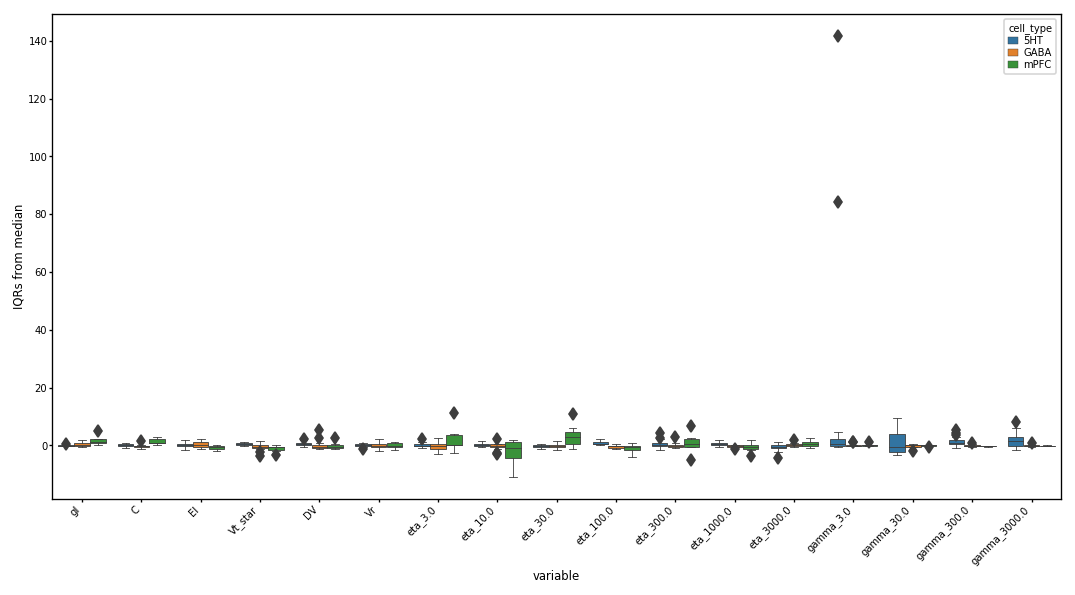

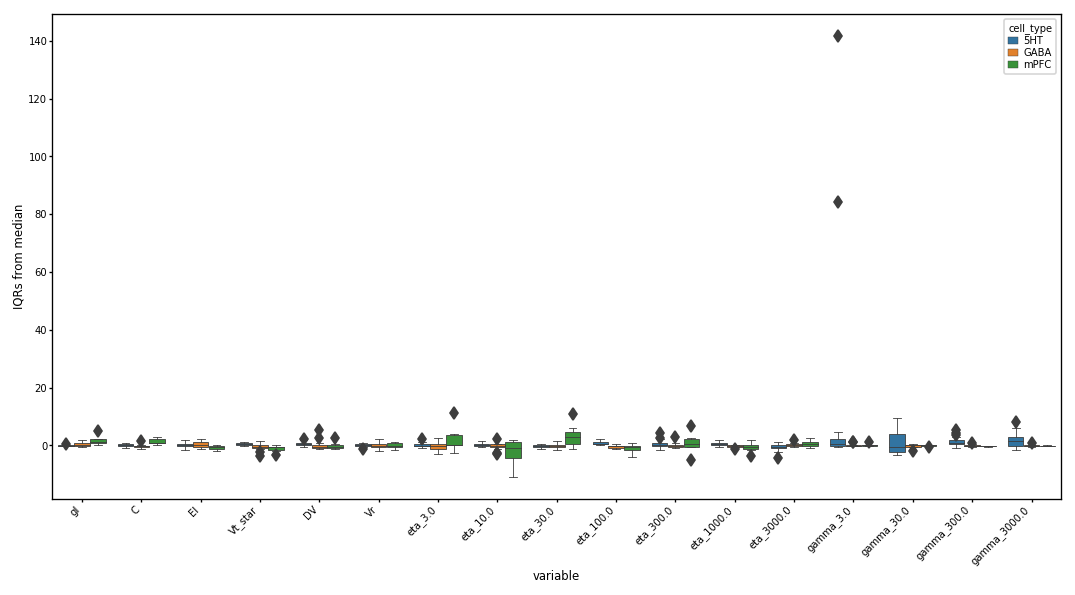

In [45]:
plt.figure(figsize=(9, 5))
sns.boxplot(
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([rescaled_nonparametric, cell_types], axis=1).melt(id_vars='cell_type'),
    order = column_order
)
#plt.ylim(-3, 3)
tick_locs, tick_labs = plt.xticks()
plt.xticks(*plt.xticks(), rotation=45, ha='right')
plt.tight_layout()
plt.ylabel('IQRs from median')

Text(111.917,0.5,'IQRs from median')

Text(111.917,0.5,'IQRs from median')

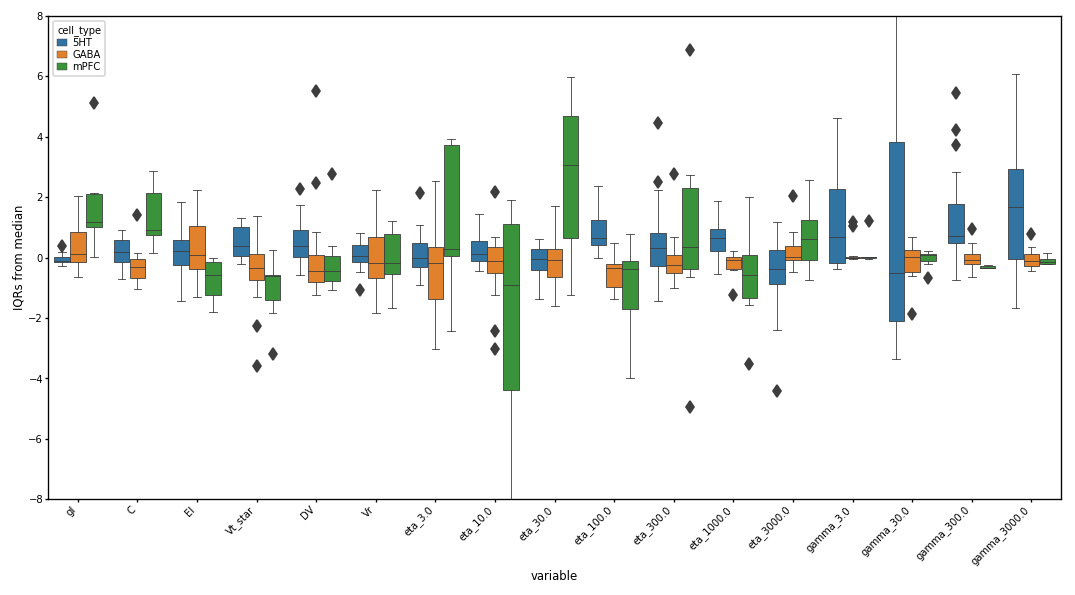

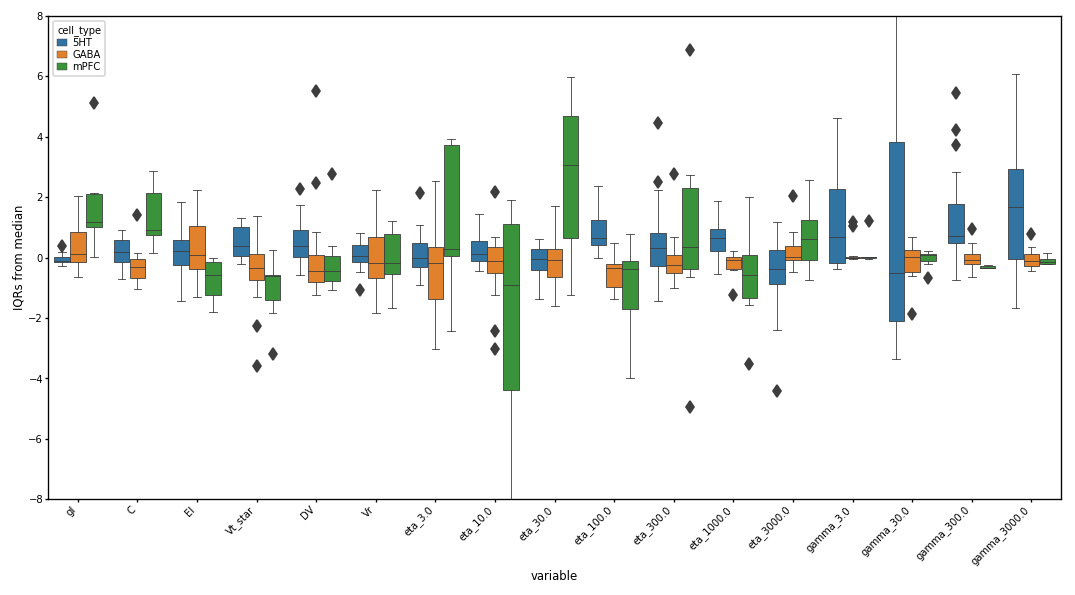

In [46]:
plt.figure(figsize=(9, 5))
sns.boxplot(
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([rescaled_nonparametric, cell_types], axis=1).melt(id_vars='cell_type'),
    order = column_order
)
plt.ylim(-8, 8)
tick_locs, tick_labs = plt.xticks()
plt.xticks(*plt.xticks(), rotation=45, ha='right')
plt.tight_layout()
plt.ylabel('IQRs from median')

In [47]:
def build_comparisons_list(x, hue):
    comparisons = []
    for level in x:
        for i in range(len(hue)):
            for j in range(i + 1, len(hue)):
                comparisons.append(
                    ((level, hue[i]), (level, hue[j]))
                )
    return comparisons

In [48]:
pvalue_thresholds = [[1e-4, '****'], [1e-3, '***'], [1e-2, '**'], [5e-2, '*'], [0.1, 'o'], [1., 'ns']]

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
C_GABA v.s. C_mPFC: Mann-Whitney-Wilcoxon test two-sided, P_val=1.173e-03 U_stat=5.000e+00
time_const_5HT v.s. time_const_GABA: Mann-Whitney-Wilcoxon test two-sided, P_val=5.016e-03 U_stat=1.800e+02
time_const_GABA v.s. time_const_mPFC: Mann-Whitney-Wilcoxon test two-sided, P_val=9.702e-01 U_stat=5.000e+01
p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
C_GABA v.s. C_mPFC: Mann-Whitney-Wilcoxon test two-sided, P_val=1.173e-03 U_stat=5.000e+00
time_const_5HT v.s. time_const_GABA: Mann-Whitney-Wilcoxon test two-sided, P_val=5.016e-03 U_stat=1.800e+02
time_const_GABA v.s. time_const_mPFC: Mann-Whitney-Wilcoxon test two-sided, P_val=9.702e-01 U_stat=5.000e

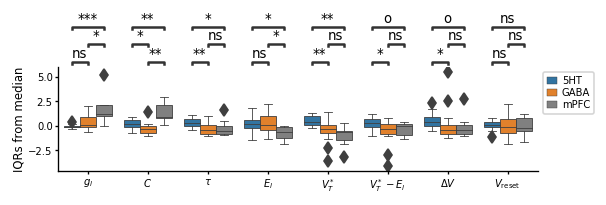

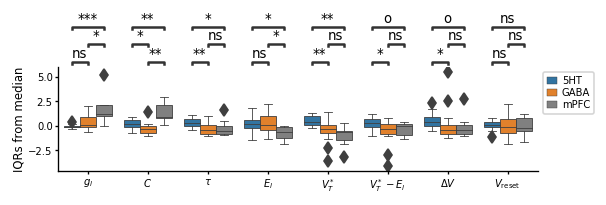

In [49]:
plt.figure(figsize=(5, 1.5))
ax = sns.boxplot(
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([rescaled_nonparametric, cell_types], axis=1).melt(id_vars='cell_type'),
    order = ['gl', 'C', 'time_const', 'El', 'Vt_star', 'thresh_dist', 'DV', 'Vr'],
    hue_order=['5HT', 'GABA', 'mPFC'],
    palette=[colors['ser'], colors['som'], colors['pyr']]
)
add_stat_annotation(
    ax,
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([rescaled_nonparametric, cell_types], axis=1).melt(id_vars='cell_type'),
    order = ['gl', 'C', 'time_const', 'El', 'Vt_star', 'thresh_dist', 'DV', 'Vr'],
    box_pairs=build_comparisons_list(
        ['gl', 'C', 'time_const', 'El', 'Vt_star', 'thresh_dist', 'DV', 'Vr'],
        ['5HT', 'mPFC', 'GABA']
    ),
    loc='outside',
    test='Mann-Whitney',
    pvalue_thresholds=pvalue_thresholds,
    comparisons_correction=None
)
tick_locs, _ = plt.xticks()
plt.xticks(
    tick_locs, 
    ['$g_l$', '$C$', r'$\tau$', '$E_l$', '$V_T^*$', '$V_T^* - E_l$', '$\Delta V$', '$V_\mathrm{reset}$']
)
plt.xlabel('')
plt.ylabel('IQRs from median')
pltools.hide_border('tr')
plt.legend(bbox_to_anchor=(1, 1))

plt.subplots_adjust(left=0.1, bottom=0.12, right=0.9, top=0.7)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'scalar_params.png'))
    plt.savefig(os.path.join(IMG_PATH, 'scalar_params.svg'))

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
eta_10.0_GABA v.s. eta_10.0_mPFC: Mann-Whitney-Wilcoxon test two-sided, P_val=5.758e-01 U_stat=5.700e+01
eta_30.0_GABA v.s. eta_30.0_mPFC: Mann-Whitney-Wilcoxon test two-sided, P_val=6.758e-02 U_stat=2.400e+01
p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
eta_10.0_GABA v.s. eta_10.0_mPFC: Mann-Whitney-Wilcoxon test two-sided, P_val=5.758e-01 U_stat=5.700e+01
eta_30.0_GABA v.s. eta_30.0_mPFC: Mann-Whitney-Wilcoxon test two-sided, P_val=6.758e-02 U_stat=2.400e+01
eta_30.0_5HT v.s. eta_30.0_GABA: Mann-Whitney-Wilcoxon test two-sided, P_val=8.516e-01 U_stat=1.170e+02
eta_100.0_GABA v.s. eta_100.0_mPFC: Mann-Whitney-Wilcoxon test two-sided, P_val=6.277e-0

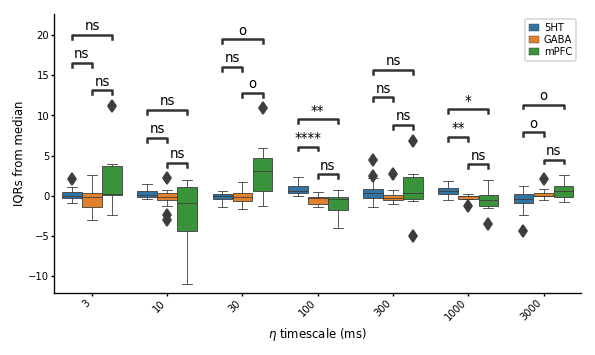

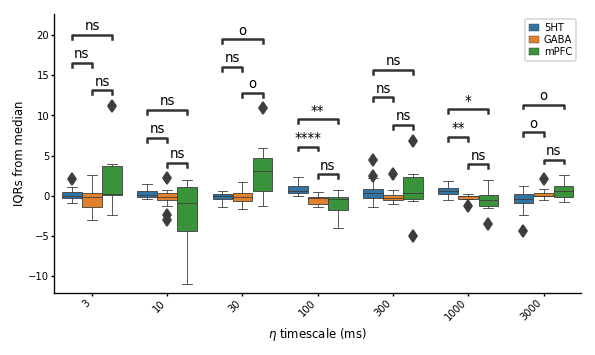

In [50]:
plt.figure(figsize=(5, 3))
ax = sns.boxplot(
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([rescaled_nonparametric, cell_types], axis=1).melt(id_vars='cell_type'),
    order = ['eta_3.0', 'eta_10.0', 'eta_30.0', 'eta_100.0', 'eta_300.0', 'eta_1000.0', 'eta_3000.0']
)
add_stat_annotation(
    ax,
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([rescaled_nonparametric, cell_types], axis=1).melt(id_vars='cell_type'),
    order = ['eta_3.0', 'eta_10.0', 'eta_30.0', 'eta_100.0', 'eta_300.0', 'eta_1000.0', 'eta_3000.0'],
    box_pairs=build_comparisons_list(
        ['eta_3.0', 'eta_10.0', 'eta_30.0', 'eta_100.0', 'eta_300.0', 'eta_1000.0', 'eta_3000.0'],
        ['mPFC', '5HT', 'GABA']
    ),
    pvalue_thresholds=pvalue_thresholds,
    test='Mann-Whitney',
    comparisons_correction=None
)
tick_locs, _ = plt.xticks()
plt.xticks(tick_locs, [3, 10, 30, 100, 300, 1000, 3000], rotation=45, ha='right')
plt.xlabel('$\eta$ timescale (ms)')
plt.tight_layout()
plt.ylabel('IQRs from median')
ax.legend(bbox_to_anchor=(1, 1))
pltools.hide_border('tr')

plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'eta_params.png'))
    plt.savefig(os.path.join(IMG_PATH, 'eta_params.svg'))

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
gamma_30.0_GABA v.s. gamma_30.0_mPFC: Mann-Whitney-Wilcoxon test two-sided, P_val=9.702e-01 U_stat=4.900e+01
gamma_300.0_GABA v.s. gamma_300.0_mPFC: Mann-Whitney-Wilcoxon test two-sided, P_val=5.147e-03 U_stat=8.700e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
gamma_30.0_GABA v.s. gamma_30.0_mPFC: Mann-Whitney-Wilcoxon test two-sided, P_val=9.702e-01 U_stat=4.900e+01
gamma_300.0_GABA v.s. gamma_300.0_mPFC: Mann-Whitney-Wilcoxon test two-sided, P_val=5.147e-03 U_stat=8.700e+01
gamma_300.0_5HT v.s. gamma_300.0_GABA: Mann-Whitney-Wilcoxon test two-sided, P_val=2.579e-03 U_stat=1.850e+02
gamma_3000.0_GABA v.s. gamma_3000.0_mPFC: Mann-Whitney-Wilcoxon test two-sided, P_val=9.702e-01 U_stat=5.000e+01
gamma

Text(47.6667,0.5,'IQRs from median')

gamma_30.0_5HT v.s. gamma_30.0_mPFC: Mann-Whitney-Wilcoxon test two-sided, P_val=7.637e-01 U_stat=5.100e+01
gamma_3.0_5HT v.s. gamma_3.0_mPFC: Mann-Whitney-Wilcoxon test two-sided, P_val=8.673e-01 U_stat=5.900e+01


Text(47.6667,0.5,'IQRs from median')

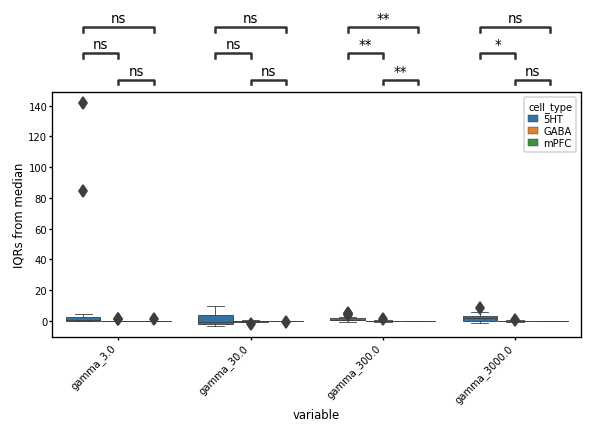

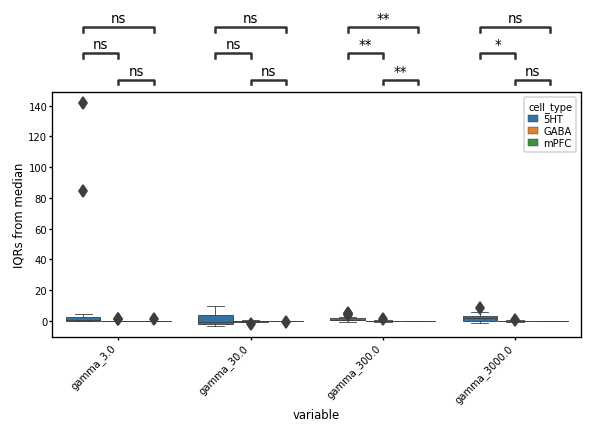

In [51]:
plt.figure(figsize=(5, 3))
ax = sns.boxplot(
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([rescaled_nonparametric, cell_types], axis=1).melt(id_vars='cell_type'),
    order = ['gamma_3.0', 'gamma_30.0', 'gamma_300.0', 'gamma_3000.0']
)
add_stat_annotation(
    ax,
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([rescaled_nonparametric, cell_types], axis=1).melt(id_vars='cell_type'),
    loc='outside',
    order = ['gamma_3.0', 'gamma_30.0', 'gamma_300.0', 'gamma_3000.0'],
    box_pairs=build_comparisons_list(
        ['gamma_3.0', 'gamma_30.0', 'gamma_300.0', 'gamma_3000.0'],
        ['mPFC', '5HT', 'GABA']
    ),
    test='Mann-Whitney',
    comparisons_correction=None
)
tick_locs, tick_labs = plt.xticks()
plt.xticks(*plt.xticks(), rotation=45, ha='right')
plt.tight_layout()
plt.ylabel('IQRs from median')


p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
gamma_30.0_GABA v.s. gamma_30.0_mPFC: Mann-Whitney-Wilcoxon test two-sided, P_val=9.702e-01 U_stat=4.900e+01
gamma_300.0_GABA v.s. gamma_300.0_mPFC: Mann-Whitney-Wilcoxon test two-sided, P_val=5.147e-03 U_stat=8.700e+01
p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
gamma_30.0_GABA v.s. gamma_30.0_mPFC: Mann-Whitney-Wilcoxon test two-sided, P_val=9.702e-01 U_stat=4.900e+01
gamma_300.0_GABA v.s. gamma_300.0_mPFC: Mann-Whitney-Wilcoxon test two-sided, P_val=5.147e-03 U_stat=8.700e+01
gamma_300.0_5HT v.s. gamma_300.0_GABA: Mann-Whitney-Wilcoxon test two-sided, P_val=2.579e-03 U_stat=1.850e+02
gamma_3000.0_GABA v.s. gamma_3000.0_mPFC: Mann-Whitney-Wilcoxo

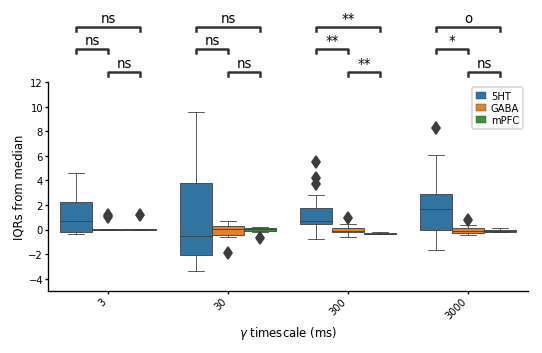

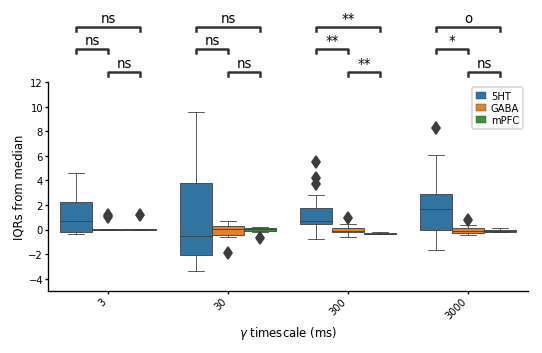

In [52]:
plt.figure(figsize=(5, 3))
plt.ylim(-5, 12)
ax = sns.boxplot(
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([rescaled_nonparametric, cell_types], axis=1).melt(id_vars='cell_type'),
    order = ['gamma_3.0', 'gamma_30.0', 'gamma_300.0', 'gamma_3000.0']
)
add_stat_annotation(
    ax,
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([rescaled_nonparametric, cell_types], axis=1).melt(id_vars='cell_type'),
    loc='outside',
    order = ['gamma_3.0', 'gamma_30.0', 'gamma_300.0', 'gamma_3000.0'],
    box_pairs=build_comparisons_list(
        ['gamma_3.0', 'gamma_30.0', 'gamma_300.0', 'gamma_3000.0'],
        ['mPFC', '5HT', 'GABA']
    ),
    test='Mann-Whitney',
    pvalue_thresholds=pvalue_thresholds,
    comparisons_correction=None
)
tick_locs, _ = plt.xticks()
plt.xticks(tick_locs, [3, 30, 300, 3000], rotation=45, ha='right')
plt.xlabel('$\gamma$ timescale (ms)')
plt.ylabel('IQRs from median')
pltools.hide_border('tr')
ax.legend(bbox_to_anchor=(1, 1))


plt.subplots_adjust(left=0.1, bottom=0.12, right=0.9, top=0.7)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'gamma_params.png'))
    plt.savefig(os.path.join(IMG_PATH, 'gamma_params.svg'))